## Multilayer Perceptrons (MLP)

### GPU selection

Select the GPU id to use.


In [1]:
# Select the right device. Change the number to select a different GPU.
# If you have used slurm to request a GPU, just keep this line as it is.
device_id = 0

In [2]:
import torch
from torch import cuda
from multiprocessing import cpu_count

# Automatic device selection
if cuda.is_available():
    torch.set_num_threads(cpu_count() // cuda.device_count())
    device = torch.device(f"cuda:{device_id}")
else:
    torch.set_num_threads(cpu_count())
    device = torch.device("cpu")
device

device(type='cuda', index=0)

### Hyperparameters

These are the hyperparameters used throughout this chapter. Placed here for
easier experiments.


In [3]:
from torch import nn, optim

# Training hyperparams
batch_size = 64
epochs = 50

# Model hyperparams
num_layers = 3
hidden_size = 256
dropout = 0.3
Activation = nn.ReLU

# Optimizer hyperparams
Optimizer = optim.Adam
lr = 1e-3

# Extra
print_every = 5

### Data preprocessing

Before introducing our first machine learning model, let's begin with a dataset
named _MNIST_ (Modified National Institute of Standards and Technology
database). This dataset will be used throughout this chapter and the next one
(CNN), so make sure to be friends with it.


In [4]:
import torchvision as tv
from torchvision.transforms.functional import to_tensor
from PIL import Image
from IPython.display import clear_output


# PyTorch provides the MNIST dataset in the torchvision library, but it is not
# optimized for GPU. To speed up training, we will use a subclass of the
# torchvision.datasets.MNIST to load the data into the memory.
class MNIST_GPU(tv.datasets.MNIST):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.data = torch.cat([
            to_tensor(Image.fromarray(img.numpy())) for img in self.data])

    # All datasets should provide an interface to get a sample (__getitem__
    # magic method). This is commonly referred to as an "operator overloading".
    def __getitem__(self, i):
        return self.data[i], self.targets[i]

    # Also, they should provide the __len__ magic method. However, the MNIST
    # class already implements it, so we could just use it via inheritance.
    # def __len__(self):
    #     return len(self.data)

    # This is just for convinience.
    def to(self, device):
        self.data = self.data.to(device)
        self.targets = self.targets.to(device)
        return self


def mnist_dataset(train: bool):
    return MNIST_GPU("resources/", train=train, download=True)


train_set = mnist_dataset(True).to(device)
clear_output(wait=True)
train_set

Dataset MNIST_GPU
    Number of datapoints: 60000
    Root location: resources/
    Split: Train

Ok, a nice little summary. What's in the dataset?


In [5]:
type(train_set.data)

torch.Tensor

In [6]:
train_set.data.shape

torch.Size([60000, 28, 28])

So, the set consists of 60,000 $28 \times 28$ single-channel (i.e., grayscale)
images. Let's take a look at the first few images.


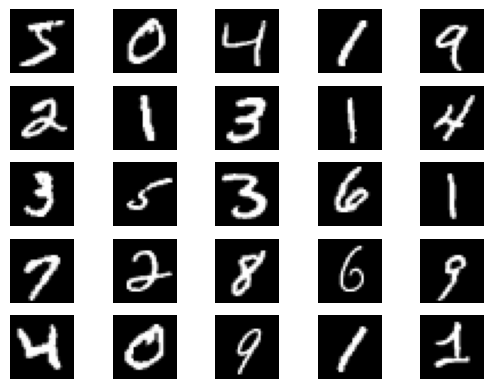

In [7]:
from matplotlib import pyplot as plt

row, col = 5, 5
fig, axes = plt.subplots(row, col)
for ax, (img, _) in zip(axes.flatten(), train_set):
    ax.imshow(img.squeeze().cpu(), cmap="gray")
    ax.axis("off")

Model parameters usually are updated via
[gradient descent](https://en.wikipedia.org/wiki/Gradient_descent)-based methods
because other global optimization techniques do not apply to millions of
billions of parameters. However, deep learning requires massive datasets that
often do not fit into memory, so optimization over the entire training set may
not be available. How can we solve this problem?

The solution to this contradiction is to divide the dataset into a sequence of
subsets, the _minibatches_, and then update model weights minibatch-wise. This
is the so-called
[_stochastic gradient descent_](https://en.wikipedia.org/wiki/Stochastic_gradient_descent).
It requires less computational memory per update than the original, at the cost
of slower convergence or even the possibility of convergence failure. Here,
shuffling can provide a better convergence by increasing the minibatch
diversity. This is why the training set is randomly shuffled before every
training epoch, whereas the validation or test set is not (not required to).

PyTorch provides an abstraction layer over the dataset, providing features such
as batching, iteration, shuffling, etc.: the `Dataloader`s. We use `Dataloader`s
to transform the dataset into minibatches, then feed them to the model. You
could think of them as python lists, which may shuffle the order of elements on
each iteration and automatically batch them for easier training.

In [8]:
from torch.utils.data import DataLoader


def to_dataloader(dataset: MNIST_GPU):
    return DataLoader(dataset, batch_size=batch_size, shuffle=dataset.train)


train_loader = to_dataloader(train_set)

### First attempt: a single-layered feed-forward network

As you can see in the previous section, The MNIST database contains handwritten
ASCII digits. Now we're going to create our first neural network. The input
dimension should be $28 \times 28 = 784$, and the final output dimension should
be, of course, $10$.


In [9]:
N = train_set.data.shape[1] * train_set.data.shape[2]
C = 10

net = nn.Linear(N, C)
net

Linear(in_features=784, out_features=10, bias=True)

Before training the network, let's count the model parameters.


In [10]:
sum(param.numel() for param in net.parameters() if param.requires_grad)

7850

Yes, yes, it's right. Sum of a $10 \times 784$ matrix and a $10$-dimension
vector. It's not even high school math.

In the real world, however, things are not as clear as this simple model,
especially for those constructing a deep learning model with multiple
sub-networks, each of which consists of many different types of layers. The code
snippet above will be your best friend shortly.

Anyway, let's start training this model.


In [11]:
from torch.nn import functional as F


@torch.no_grad()
def accuracy(y_hat: torch.Tensor, y: torch.Tensor):
    return (y_hat.argmax(dim=1) == y).float().mean()


def train(model: nn.Module, loader: DataLoader, optimizer: optim.Optimizer):
    model.train()

    epoch_loss = []
    epoch_accu = []

    for x, y in loader:
        # Zero out the gradients from the last training phase.
        # Otherwise, the gradients will be accumulated over the iterations.
        optimizer.zero_grad()
        # Shape: [B, H, W] -> [B, H * W]
        x = torch.flatten(x, 1)
        # Shape: [B, C]
        y_hat = model(x)
        # calculate loss
        loss = F.cross_entropy(y_hat, y)
        # Back-propagation
        loss.backward()
        # Parameter update
        optimizer.step()

        # Record the loss and accuracy
        epoch_loss.append(loss.item())
        epoch_accu.append(accuracy(y_hat, y))

    return torch.tensor(epoch_loss).mean(), torch.tensor(epoch_accu).mean()

Don't forget to test it!


In [12]:
valid_set = mnist_dataset(False).to(device)
valid_loader = to_dataloader(valid_set)


@torch.no_grad()
def validate(model: nn.Module, loader: DataLoader):
    model.eval()

    epoch_loss = []
    epoch_accu = []

    for x, y in loader:
        # Shape: [B, H, W] -> [B, H * W]
        x = torch.flatten(x, 1)
        # Shape: [B, C]
        y_hat = model(x)
        # calculate loss
        loss = F.cross_entropy(y_hat, y)

        # Record the loss and accuracy
        epoch_loss.append(loss.item())
        epoch_accu.append(accuracy(y_hat, y))

    return torch.tensor(epoch_loss).mean(), torch.tensor(epoch_accu).mean()

It's time for our first run. Quite thrilling, isn't it?


In [13]:
from tqdm.auto import tqdm, trange
from collections import defaultdict


def train_mlp(model: nn.Module, train_loader: DataLoader,
              valid_loader: DataLoader):
    optimizer = Optimizer(net.parameters(), lr=lr)
    stats = defaultdict(list)

    for epoch in trange(1, epochs + 1):
        train_loss, train_accu = train(model, train_loader, optimizer)
        valid_loss, valid_accu = validate(model, valid_loader)

        stats["epoch"] += [epoch] * 4
        stats["run"] += ["train", "train", "valid", "valid"]
        stats["type"] += ["loss", "accuracy"] * 2
        stats["stat"] += [train_loss, train_accu, valid_loss, valid_accu]

        if not epoch % print_every:
            tqdm.write((f"{train_loss = :.4f}, {train_accu = :.2%}, "
                        f"{valid_loss = :.4f}, {valid_accu = :.2%}"))

    return stats

In [14]:
net = net.to(device)
stats = train_mlp(net, train_loader, valid_loader)

  0%|          | 0/50 [00:00<?, ?it/s]

train_loss = 0.2737, train_accu = 92.39%, valid_loss = 0.2684, valid_accu = 92.53%
train_loss = 0.2546, train_accu = 92.95%, valid_loss = 0.2635, valid_accu = 92.74%
train_loss = 0.2466, train_accu = 93.19%, valid_loss = 0.2608, valid_accu = 92.75%
train_loss = 0.2417, train_accu = 93.36%, valid_loss = 0.2654, valid_accu = 92.77%
train_loss = 0.2383, train_accu = 93.45%, valid_loss = 0.2654, valid_accu = 92.81%
train_loss = 0.2357, train_accu = 93.46%, valid_loss = 0.2663, valid_accu = 92.79%
train_loss = 0.2334, train_accu = 93.58%, valid_loss = 0.2677, valid_accu = 92.85%
train_loss = 0.2318, train_accu = 93.62%, valid_loss = 0.2725, valid_accu = 92.68%
train_loss = 0.2303, train_accu = 93.66%, valid_loss = 0.2779, valid_accu = 92.62%
train_loss = 0.2293, train_accu = 93.72%, valid_loss = 0.2751, valid_accu = 92.76%


Let's also plot the statistics.


In [15]:
import numpy as np
import seaborn as sns

sns.set_theme(style="whitegrid", palette="muted")


def plot_stats(stats: dict):
    for k, v in stats.items():
        stats[k] = np.array(v)

    sns.relplot(x="epoch", y="stat", hue="run", col="type", data=stats,
                kind="line", facet_kws={"sharey": False, "xlim": (0, epochs)})
    plt.show()

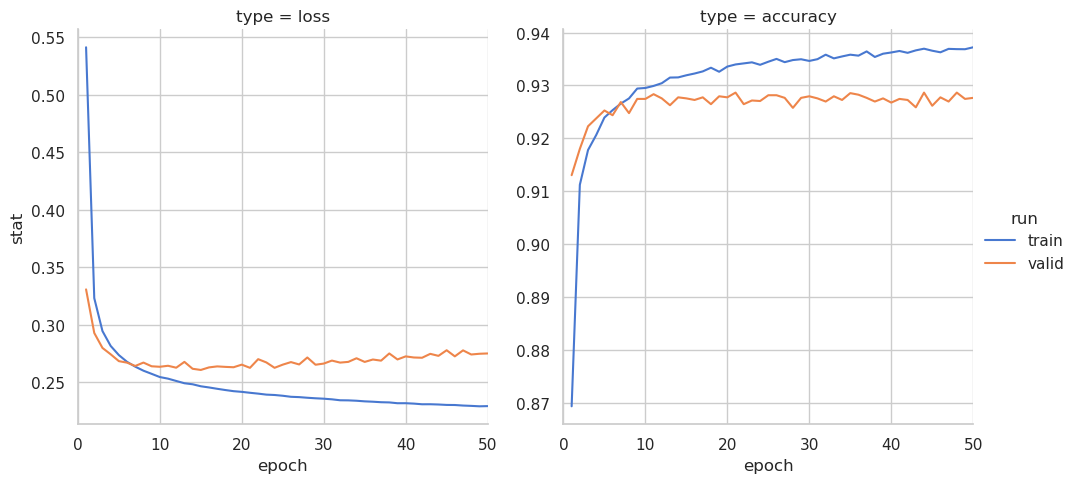

In [16]:
plot_stats(stats)

Two interesting points:

- The single-layered model **is** quite accurate!
- Training loss always decreases; however, validation loss increases after some
  time. This is the _overfitting_ problem.


### Second attempt: a multilayer perceptron

Now it's time to introduce the _real_ deep learning model: a multilayer
perceptron.


In [17]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        if num_layers < 1:
            raise ValueError("num_layers must be >= 1")
        elif num_layers == 1:
            self.net = nn.Linear(N, C)
        else:
            nets = [self._block(N, hidden_size)]
            for _ in range(num_layers - 2):
                nets.append(self._block(hidden_size, hidden_size))
            # Q) The last layer does not require an activation or a dropout.
            # Why?
            nets.append(nn.Linear(hidden_size, C))
            self.net = nn.Sequential(*nets)

    # All models must implement a forward method. This will be called by the
    # training loop (via a function call operator).
    def forward(self, X):
        return self.net(X)

    @staticmethod
    def _block(in_size, out_size):
        return nn.Sequential(nn.Linear(in_size, out_size),
                             Activation(),
                             nn.Dropout(dropout))


def get_dataloaders():
    return to_dataloader(train_set), to_dataloader(valid_set)

Train again, then plot the stats again...


MLP(
  (net): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
    )
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)


  0%|          | 0/50 [00:00<?, ?it/s]

train_loss = 0.0752, train_accu = 97.67%, valid_loss = 0.0689, valid_accu = 97.89%
train_loss = 0.0492, train_accu = 98.38%, valid_loss = 0.0682, valid_accu = 97.99%
train_loss = 0.0363, train_accu = 98.77%, valid_loss = 0.0663, valid_accu = 98.44%
train_loss = 0.0343, train_accu = 98.87%, valid_loss = 0.0791, valid_accu = 98.17%
train_loss = 0.0294, train_accu = 99.04%, valid_loss = 0.0638, valid_accu = 98.53%
train_loss = 0.0274, train_accu = 99.15%, valid_loss = 0.0672, valid_accu = 98.51%
train_loss = 0.0259, train_accu = 99.19%, valid_loss = 0.0779, valid_accu = 98.41%
train_loss = 0.0239, train_accu = 99.25%, valid_loss = 0.0923, valid_accu = 98.17%
train_loss = 0.0206, train_accu = 99.35%, valid_loss = 0.0819, valid_accu = 98.47%
train_loss = 0.0202, train_accu = 99.36%, valid_loss = 0.0831, valid_accu = 98.48%


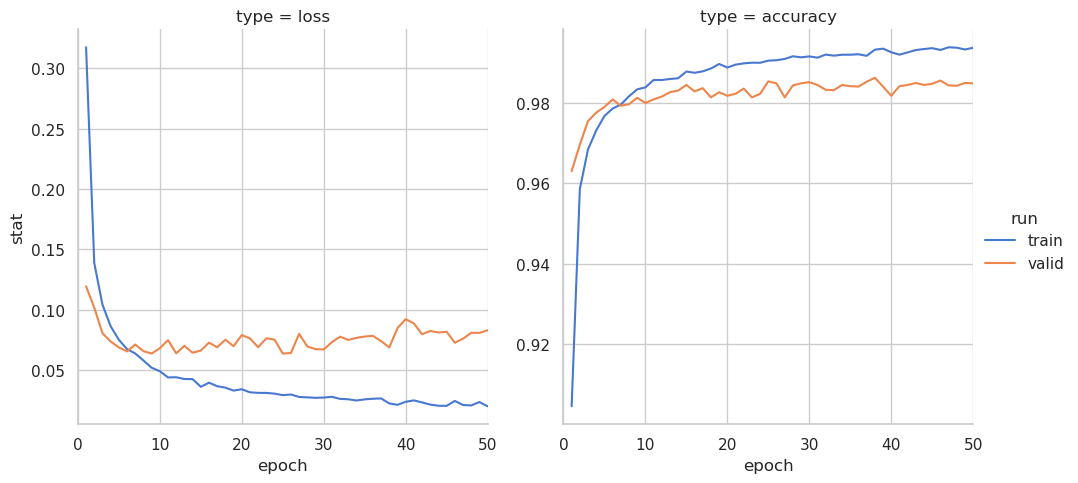

In [18]:
train_loader, valid_loader = get_dataloaders()

net = MLP().to(device)
# Visualize the model
print(net)

stats = train_mlp(net, train_loader, valid_loader)
plot_stats(stats)

### Hyperparameter optimization

Now it's your turn. Get back to the beginning of this notebook, and change the
hyperparameters. Run the above cell again and again until the best combination
(i.e., the combination with the highest validation accuracy) is found. Good
luck!

> _HINT: getting over 99% is **very** hard._
